In [1]:
## 数据工具包
import numpy as np
np.random.seed(42)
import pandas as pd
from tqdm import tqdm,tqdm_notebook

## 字符串处理工具包
import string
import re
# import gensim
from collections import Counter
import pickle
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
# from keras.preprocessing import text, sequence 

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
import lightgbm as lgb
from functools import partial

import os 
import gc
from scipy.sparse import vstack  
import time
import datetime

import joblib

import multiprocessing as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline
import seaborn as sns 
%matplotlib inline

In [2]:
# from tqdm import tqdm
# from tqdm import tqdm_notebook

# path ='D:/Program Projects/Python Projects/temp/地铁乘客流量预测/input/'
# for i in tqdm(range(1,26)):
#     if i < 10:
#         train_tmp = pd.read_csv(path + 'Metro_train/record_2019-01-0' + str(i) + '.csv')
#     else:
#         train_tmp = pd.read_csv(path + 'Metro_train/record_2019-01-' + str(i) + '.csv')
#     if i== 1:
#         data = train_tmp
#     else:
#         data = pd.concat([data, train_tmp],axis=0,ignore_index=True) 
        
# Metro_roadMap = pd.read_csv(path + 'Metro_roadMap.csv')

# test_A_record = pd.read_csv(path + 'Metro_testA/testA_record_2019-01-28.csv') 
# test_A_submit = pd.read_csv(path + 'Metro_testA/testA_submit_2019-01-29.csv') 

# data = pd.concat([data, test_A_record],axis=0,ignore_index=True)

# 以1号到25号 外加28号的数据做训练集
# 以29号的数据做测试集

path ='D:/Program Projects/Python Projects/temp/地铁乘客流量预测/input/'
for i in tqdm(range(1,26)):
    if i < 10:
        train_tmp = pd.read_csv(path + 'Metro_train/record_2019-01-0' + str(i) + '.csv')
    else:
        train_tmp = pd.read_csv(path + 'Metro_train/record_2019-01-' + str(i) + '.csv')
    if i == 1:
        data = train_tmp
    else:
        data = pd.concat([data, train_tmp],axis=0,ignore_index=True)
Metro_roadMap = pd.read_csv(path + 'Metro_roadMap.csv')
test_A_record = pd.read_csv(path + 'Metro_testA/testA_record_2019-01-28.csv')
test_A_submit = pd.read_csv(path + 'Metro_testA/testA_submit_2019-01-29.csv')
data = pd.concat([data, test_A_record],axis=0,ignore_index=True)

100%|██████████| 25/25 [00:54<00:00,  2.16s/it]


In [3]:
def trans_time_10_minutes(x):
    x_split = x.split(':')
    x_part1 = x_split[0]
    x_part2 = int(x_split[1]) // 10
    if x_part2 == 0:
        x_part2 = '00'
    else:
        x_part2 = str(x_part2 * 10)
    return x_part1 + ':' + x_part2 + ':00'

In [4]:
data['time'] = pd.to_datetime(data['time'])
data['time_10_minutes'] = data['time'].astype(str).apply(lambda x: trans_time_10_minutes(x))

In [5]:
data_inNums = data[data.status == 1].groupby(['stationID','time_10_minutes']).size().to_frame('inNums').reset_index()
data_inNums.head() 

,stationID,time_10_minutes,inNums
0,0,2019-01-01 05:30:00,1
1,0,2019-01-01 05:40:00,4
2,0,2019-01-01 05:50:00,3
3,0,2019-01-01 06:00:00,17
4,0,2019-01-01 06:10:00,21


In [6]:
data_outNums = data[data.status == 0].groupby(['stationID','time_10_minutes']).size().to_frame('outNums').reset_index()
data_outNums.head() 

,stationID,time_10_minutes,outNums
0,0,2019-01-01 05:50:00,1
1,0,2019-01-01 06:20:00,1
2,0,2019-01-01 06:30:00,49
3,0,2019-01-01 06:40:00,48
4,0,2019-01-01 06:50:00,25


In [7]:
stationIDs = test_A_submit['stationID'].unique()
times = [] 
days = [i for i in range(1,26)] + [28, 29]
for day in days: 
    if day < 10:
        day_str = '0' + str(day)
    else:
        day_str = str(day)
    for hour in range(24):
        if hour < 10:
            hour_str = '0' + str(hour)
        else:
            hour_str = str(hour)
        for minutes in range(6):
            if minutes == 0:
                minutes_str = '0' + str(minutes)
            else:
                minutes_str = str(minutes * 10) 
            times.append('2019-01-' + day_str + ' ' + hour_str +':' + minutes_str + ':00')

# 求笛卡儿积
from itertools import product
stationids_by_times = list(product(stationIDs, times))
# 构建新的数据集
df_data = pd.DataFrame()
df_data['stationID'] = np.array(stationids_by_times)[:,0]
df_data['startTime'] = np.array(stationids_by_times)[:,1]
df_data = df_data.sort_values(['stationID','startTime'])
df_data['endTime'] = df_data.groupby('stationID')['startTime'].shift(-1).values

In [8]:
def filltime(x):
    x_split = x.split(' ')[0].split('-')
    x_part1_1 = x_split[0] +'-'+x_split[1]+'-'
    x_part1_2 = int(x_split[2]) + 1
    if x_part1_2 < 10:
        x_part1_2 = '0' + str(x_part1_2)
    else:
        x_part1_2 = str(x_part1_2)
        
    x_part2 = ' 00:00:00'
    return x_part1_1 + x_part1_2 + x_part2
# 缺失值时间填充
df_data.loc[df_data.endTime.isnull(), 'endTime']  = \
df_data.loc[df_data.endTime.isnull(), 'startTime'].apply(lambda x: filltime(x)) 
df_data['stationID'] = df_data['stationID'].astype(int)

In [9]:
data_inNums.rename(columns={'time_10_minutes':'startTime'}, inplace=True)
data_outNums.rename( columns={'time_10_minutes':'startTime'}, inplace=True)

df_data = df_data.merge(data_inNums , on=['stationID', 'startTime'], how='left')
df_data = df_data.merge(data_outNums, on=['stationID', 'startTime'], how='left')
df_data['inNums']  = df_data['inNums'].fillna(0)
df_data['outNums'] = df_data['outNums'].fillna(0)

In [10]:
# 时间相关特征
df_data['time'] = pd.to_datetime(df_data['startTime'])
df_data['day'] = df_data['time'].dt.day  
df_data['hours_in_day'] = df_data['time'].dt.hour 
df_data['day_of_week'] = df_data['time'].dt.dayofweek 
df_data['ten_minutes_in_day'] = df_data['hours_in_day'] * 6 + df_data['time'].dt.minute // 10 
del df_data['time']

In [11]:
df_data.head()

,stationID,startTime,endTime,inNums,outNums,day,hours_in_day,day_of_week,ten_minutes_in_day
0,0,2019-01-01 00:00:00,2019-01-01 00:10:00,0.0,0.0,1,0,1,0
1,0,2019-01-01 00:10:00,2019-01-01 00:20:00,0.0,0.0,1,0,1,1
2,0,2019-01-01 00:20:00,2019-01-01 00:30:00,0.0,0.0,1,0,1,2
3,0,2019-01-01 00:30:00,2019-01-01 00:40:00,0.0,0.0,1,0,1,3
4,0,2019-01-01 00:40:00,2019-01-01 00:50:00,0.0,0.0,1,0,1,4


In [12]:
# 剔除与测试集分布差异大的日期
df_data = df_data.loc[((df_data.day_of_week < 5) & (df_data.day != 1))].copy()

In [13]:
# 保留日期
retain_days = list(df_data.day.unique())
# 重新计算rank,方便我们后续提取特征
days_relative = {} 
for i,d in enumerate(retain_days):
    days_relative[d] = i + 1

df_data['days_relative'] = df_data['day'].map(days_relative)

print(days_relative)

{np.int32(2): 1, np.int32(3): 2, np.int32(4): 3, np.int32(7): 4, np.int32(8): 5, np.int32(9): 6, np.int32(10): 7, np.int32(11): 8, np.int32(14): 9, np.int32(15): 10, np.int32(16): 11, np.int32(17): 12, np.int32(18): 13, np.int32(21): 14, np.int32(22): 15, np.int32(23): 16, np.int32(24): 17, np.int32(25): 18, np.int32(28): 19, np.int32(29): 20}


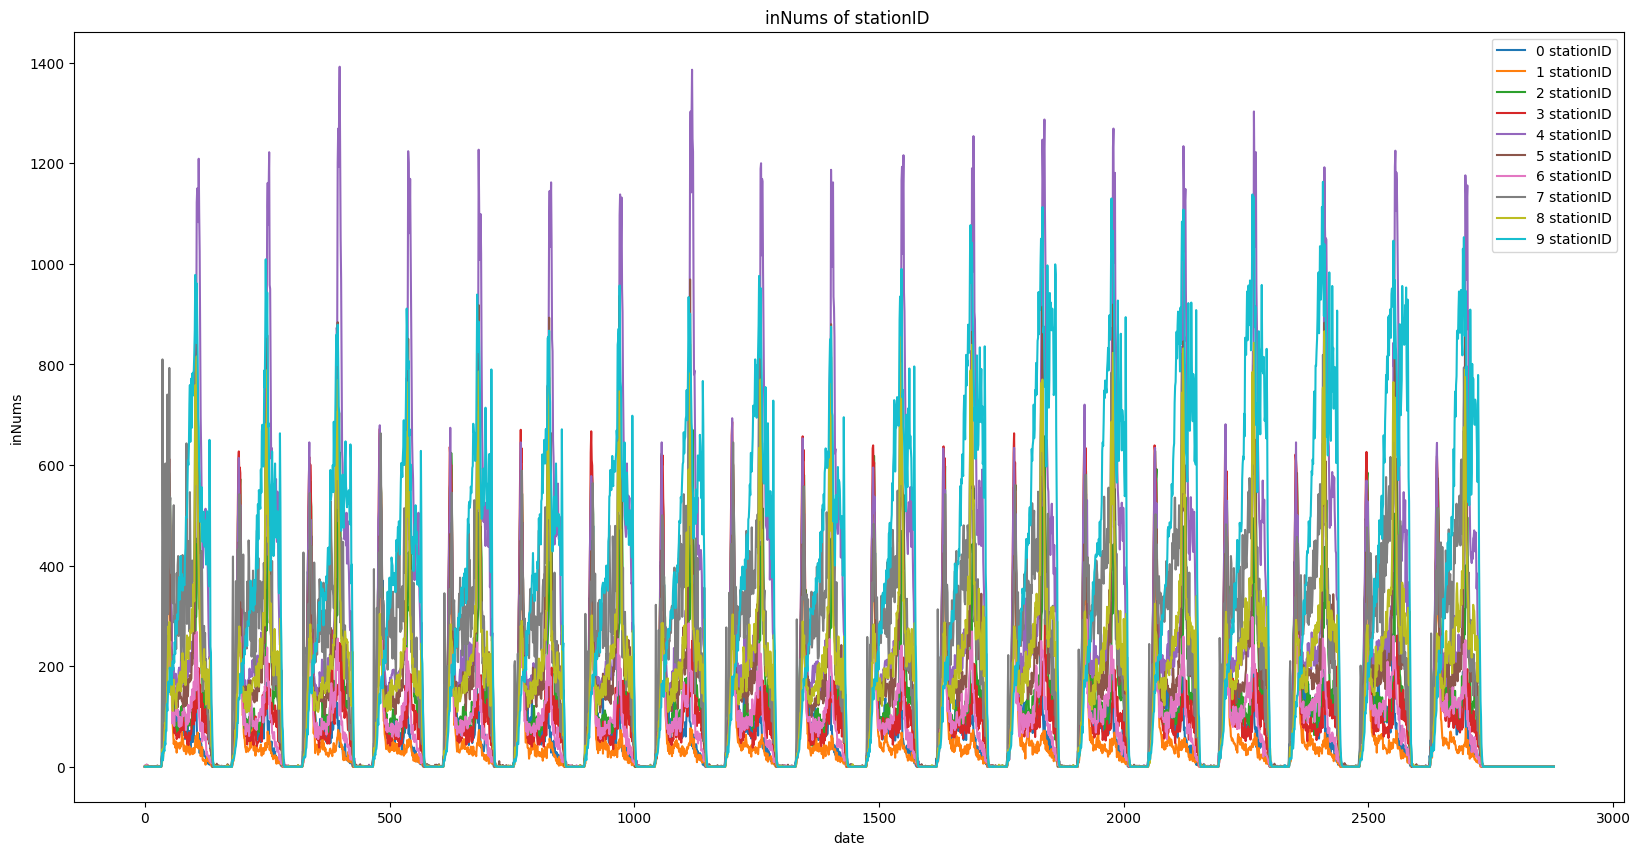

In [14]:
dt = [r for r in range(df_data.loc[df_data.stationID==0, 'ten_minutes_in_day'].shape[0])]

fig = plt.figure(1,figsize=[20,10])
plt.ylabel('inNums')
plt.xlabel('date')
plt.title('inNums of stationID ')

for i in range(0,10):
    plt.plot(dt, df_data.loc[df_data.stationID==i, 'inNums'], label = str(i)+' stationID' )
    
plt.legend()
plt.show()

In [15]:
path ='D:/Program Projects/Python Projects/temp/地铁乘客流量预测/input/'
def get_stationID_fea(df):
    df_station               = pd.DataFrame()
    df_station['stationID']  = df['stationID'].unique()
    df_station               = df_station.sort_values('stationID')
    
    tmp1  = df.groupby(['stationID'])['deviceID'].nunique().to_frame('stationID_deviceID_nunique').reset_index()
    tmp2  = df.groupby(['stationID'])['userID'].nunique().to_frame('stationID_userID_nunique').reset_index()
    
    df_station = df_station.merge(tmp1,on ='stationID', how='left')
    df_station = df_station.merge(tmp2,on ='stationID', how='left')
    
    for pivot_cols in tqdm(['payType','hour','days_relative','ten_minutes_in_day']): 
        
        tmp = df.groupby(['stationID',pivot_cols])['deviceID'].count().to_frame('stationID_'+pivot_cols+'_cnt').reset_index()
        df_tmp = tmp.pivot(index = 'stationID', columns=pivot_cols, values='stationID_'+pivot_cols+'_cnt')
        cols   = ['stationID_'+pivot_cols+'_cnt' + str(col) for col in df_tmp.columns]
        df_tmp.columns = cols
        df_tmp.reset_index(inplace = True)
        df_station = df_station.merge(df_tmp, on ='stationID', how='left')
    return df_station

for i in tqdm([21, 22, 23, 24, 25]):
    if i < 10:
        train_tmp = pd.read_csv(path + 'Metro_train/record_2019-01-0' + str(i) + '.csv')
    else:
        train_tmp = pd.read_csv(path + 'Metro_train/record_2019-01-' + str(i) + '.csv')
    if i== 21:
        df_station = train_tmp
    else:
        df_station = pd.concat([df_station, train_tmp],axis=0,ignore_index=True) 

df_station['time']               = pd.to_datetime(df_station['time'])
df_station['day']                = df_station['time'].dt.day  
df_station['week']               = df_station['time'].dt.dayofweek 
df_station['hour']               = df_station['time'].dt.hour 
df_station['ten_minutes_in_day'] = df_station['hour'] * 6 + df_station['time'].dt.minute // 10 
df_station['time_ten_minutes']   = df_station['time'].astype(str).apply(lambda x: trans_time_10_minutes(x))
df_station['days_relative']      = df_station['day'].map(days_relative)
df_station = get_stationID_fea(df_station)

100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


In [16]:
df_station

,stationID,stationID_deviceID_nunique,stationID_userID_nunique,stationID_payType_cnt0,stationID_payType_cnt1,stationID_payType_cnt2,stationID_payType_cnt3,stationID_hour_cnt0,stationID_hour_cnt1,stationID_hour_cnt2,...,stationID_ten_minutes_in_day_cnt134,stationID_ten_minutes_in_day_cnt135,stationID_ten_minutes_in_day_cnt136,stationID_ten_minutes_in_day_cnt137,stationID_ten_minutes_in_day_cnt138,stationID_ten_minutes_in_day_cnt139,stationID_ten_minutes_in_day_cnt140,stationID_ten_minutes_in_day_cnt141,stationID_ten_minutes_in_day_cnt142,stationID_ten_minutes_in_day_cnt143
0,0,18,54056,9412,33613,41965,36107,17.0,NaN,NaN,...,296.0,334.0,283.0,210.0,127.0,115.0,102.0,60.0,34.0,30.0
1,1,13,24843,11116,29935,22439,6170,21.0,NaN,NaN,...,437.0,373.0,407.0,283.0,193.0,160.0,105.0,64.0,77.0,11.0
2,2,14,67850,29234,79350,72118,12410,8.0,4.0,NaN,...,1017.0,852.0,627.0,420.0,388.0,271.0,236.0,156.0,56.0,46.0
3,3,14,51174,23130,56374,50150,7235,33.0,4.0,NaN,...,683.0,643.0,674.0,496.0,291.0,272.0,93.0,127.0,57.0,31.0
4,4,28,136676,64739,161371,139151,22849,58.0,18.0,2.0,...,1969.0,1626.0,1197.0,744.0,454.0,374.0,224.0,100.0,80.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,76,26,71635,36631,70724,55345,11807,8.0,NaN,1.0,...,338.0,262.0,202.0,159.0,90.0,38.0,18.0,5.0,NaN,1.0
76,77,26,59185,36302,72005,45364,6566,34.0,52.0,6.0,...,716.0,613.0,434.0,265.0,177.0,97.0,35.0,7.0,13.0,1.0
77,78,17,73488,31911,77885,56176,11529,4.0,2.0,NaN,...,1039.0,1073.0,695.0,524.0,317.0,216.0,140.0,28.0,20.0,NaN
78,79,13,27677,9038,26453,19265,7046,2.0,3.0,3.0,...,278.0,296.0,192.0,152.0,95.0,61.0,56.0,9.0,7.0,13.0


In [17]:
def time_before_trans(x,dic_):
    if x in dic_.keys():
        return dic_[x]
    else:
        return np.nan
def generate_fea_y(df, day, n):
    df_feature_y   =  df.loc[df.days_relative == day].copy() 
    
    df_feature_y['tmp_10_minutes'] = df_feature_y['stationID'].values * 1000 +\
    df_feature_y['ten_minutes_in_day'].values
    df_feature_y['tmp_hours']      = df_feature_y['stationID'].values * 1000 +\
    df_feature_y['hours_in_day'].values
    
    for i in range(1, n): # 前第几天
        d = day - i
        df_d = df.loc[df.days_relative == d].copy() # 当天的数据
        
        # 特征1：过去在该时间段（一样的时间段,10minutes）有多少出入量
        df_d['tmp_10_minutes'] = df['stationID'] * 1000 + df['ten_minutes_in_day']  
        df_d['tmp_hours']      = df['stationID'] * 1000 + df['hours_in_day']
        # sum 进一步考虑mean/meidan/max/min/std等统计量
        dic_innums  = df_d.groupby(['tmp_10_minutes'])['inNums'].sum().to_dict()
        dic_outnums = df_d.groupby(['tmp_10_minutes'])['outNums'].sum().to_dict()
        df_feature_y['_bf_' + str(day-d) + '_innum_10minutes']  =\
                                df_feature_y['tmp_10_minutes'].map(dic_innums).values
        df_feature_y['_bf_' + str(day-d) + '_outnum_10minutes'] =\
                               df_feature_y['tmp_10_minutes'].map(dic_outnums).values
        
        # 特征2：过去在该时间段（小时）有多少出入量
        dic_innums  = df_d.groupby(['tmp_hours'])['inNums'].sum().to_dict()
        dic_outnums = df_d.groupby(['tmp_hours'])['outNums'].sum().to_dict()   
        df_feature_y['_bf_' + str(day-d) + '_innum_hour']  =\
                              df_feature_y['tmp_hours'].map(dic_innums).values
        df_feature_y['_bf_' + str(day-d) + '_outnum_hour'] =\
                              df_feature_y['tmp_hours'].map(dic_outnums).values   
        
        # 特征3: 上10分钟
        df_d['tmp_10_minutes_bf'] = df['stationID'] * 1000 + df['ten_minutes_in_day'] - 1
        df_d['tmp_hours_bf']      = df['stationID'] * 1000 + df['hours_in_day'] - 1
        # sum
        dic_innums  = df_d.groupby(['tmp_10_minutes_bf'])['inNums'].sum().to_dict()
        dic_outnums = df_d.groupby(['tmp_10_minutes_bf'])['outNums'].sum().to_dict()
        df_feature_y['_bf1_' + str(day-d) + '_innum_10minutes']  =\
                      df_feature_y['tmp_10_minutes'].agg(lambda x: time_before_trans(x,dic_innums)).values
        df_feature_y['_bf1_' + str(day-d) + '_outnum_10minutes'] =\
                      df_feature_y['tmp_10_minutes'].agg(lambda x: time_before_trans(x,dic_outnums)).values
        
        # 特征4： 上个小时情况
        dic_innums  = df_d.groupby(['tmp_hours_bf'])['inNums'].sum().to_dict()
        dic_outnums = df_d.groupby(['tmp_hours_bf'])['outNums'].sum().to_dict()   
        df_feature_y['_bf1_' + str(day-d) + '_innum_hour']  =\
                                      df_feature_y['tmp_hours'].map(dic_innums).values
        df_feature_y['_bf1_' + str(day-d) + '_outnum_hour'] =\
                                      df_feature_y['tmp_hours'].map(dic_outnums).values
        
    for col in ['tmp_10_minutes','tmp_hours']:
        del df_feature_y[col]
        
    return df_feature_y 

In [18]:
df_feature_y = pd.DataFrame()
left = 6
right = df_data['days_relative'].max() + 1
for day in range(left,right):
    df_feature_y =  df_feature_y._append(generate_fea_y(df_data, day = day, n=left))

In [19]:
df_feature_y

,stationID,startTime,endTime,inNums,outNums,day,hours_in_day,day_of_week,ten_minutes_in_day,days_relative,...,_bf1_4_innum_hour,_bf1_4_outnum_hour,_bf_5_innum_10minutes,_bf_5_outnum_10minutes,_bf_5_innum_hour,_bf_5_outnum_hour,_bf1_5_innum_10minutes,_bf1_5_outnum_10minutes,_bf1_5_innum_hour,_bf1_5_outnum_hour
1152,0,2019-01-09 00:00:00,2019-01-09 00:10:00,0.0,0.0,9,0,2,0,6,...,0.0,0.0,0.0,4.0,0.0,7.0,0.0,0.0,0.0,0.0
1153,0,2019-01-09 00:10:00,2019-01-09 00:20:00,0.0,0.0,9,0,2,1,6,...,0.0,0.0,0.0,0.0,0.0,7.0,0.0,3.0,0.0,0.0
1154,0,2019-01-09 00:20:00,2019-01-09 00:30:00,0.0,0.0,9,0,2,2,6,...,0.0,0.0,0.0,3.0,0.0,7.0,0.0,0.0,0.0,0.0
1155,0,2019-01-09 00:30:00,2019-01-09 00:40:00,0.0,0.0,9,0,2,3,6,...,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0
1156,0,2019-01-09 00:40:00,2019-01-09 00:50:00,0.0,2.0,9,0,2,4,6,...,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314923,9,2019-01-29 23:10:00,2019-01-29 23:20:00,0.0,0.0,29,23,1,139,20,...,NaN,NaN,45.0,10.0,148.0,58.0,6.0,7.0,NaN,NaN
314924,9,2019-01-29 23:20:00,2019-01-29 23:30:00,0.0,0.0,29,23,1,140,20,...,NaN,NaN,6.0,7.0,148.0,58.0,0.0,6.0,NaN,NaN
314925,9,2019-01-29 23:30:00,2019-01-29 23:40:00,0.0,0.0,29,23,1,141,20,...,NaN,NaN,0.0,6.0,148.0,58.0,0.0,10.0,NaN,NaN
314926,9,2019-01-29 23:40:00,2019-01-29 23:50:00,0.0,0.0,29,23,1,142,20,...,NaN,NaN,0.0,10.0,148.0,58.0,0.0,2.0,NaN,NaN


In [20]:
# 特征强化
columns = ['_innum_10minutes','_outnum_10minutes','_innum_hour','_outnum_hour']
# # 过去n天的sum,mean
for i in range(2,left):
    for f in columns:
        colname1 = '_bf_'+str(i)+'_'+'days'+f+'_sum'
        df_feature_y[colname1] = 0
        for d in range(1,i+1):
            df_feature_y[colname1] = df_feature_y[colname1] + df_feature_y['_bf_'+str(d) +f]
        colname2 = '_bf_'+str(d)+'_'+'days'+f+'_mean'
        df_feature_y[colname2] = df_feature_y[colname1] / i
        
# 过去n天的mean的差分
for i in range(2,left): 
    for f in columns:
        colname1 = '_bf_'+str(d)+'_'+'days'+f+'_mean'
        colname2 = '_bf_'+str(d)+'_'+'days'+f+'_mean_diff'
        df_feature_y[colname2] = df_feature_y[colname1].diff(1)
        # 对一天的第一个时刻进行处理
        df_feature_y.loc[(df_feature_y.hours_in_day==0)&(df_feature_y.ten_minutes_in_day==0), colname2] = 0

In [21]:
def get_stationID_fea(df):
    df_station               = pd.DataFrame()
    df_station['stationID']  = df['stationID'].unique()
    cols = [str(i) for i in range(81)]  
    df_station['num_of_join_points'] = df[cols].sum(axis=1).sort_values()
    return df_station

Metro_roadMap.rename(columns={'Unnamed: 0':'stationID'},inplace=True)
df_station_metro = get_stationID_fea(Metro_roadMap)

In [22]:
df_data = df_feature_y.copy()
df_data = df_data.merge(df_station, on ='stationID', how='left')
df_data = df_data.merge(df_station_metro, on ='stationID', how='left')

In [23]:
cols = [f for f in df_data.columns if f not in ['startTime','endTime','inNums','outNums']]

In [24]:
df_train = df_data[df_data.day<28]
df_valid = df_data[df_data.day==28]

X_train = df_train[cols].values
X_valid = df_valid[cols].values

y_train_inNums = df_train['inNums'].values
y_valid_inNums = df_valid['inNums'].values

y_train_outNums = df_train['outNums'].values
y_valid_outNums = df_valid['outNums'].values

## LightGBM模型

In [25]:
# 开始训练
params = {'num_leaves': 63,'objective': 'regression_l1','max_depth': 5,'feature_fraction': 0.9,
         'learning_rate': 0.05,'boosting': 'gbdt','metric': 'mae','lambda_l1': 0.1}
model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
from lightgbm import log_evaluation, early_stopping
callbacks = [log_evaluation(period=100), early_stopping(stopping_rounds=200)]
model.fit(X_train, y_train_inNums, 
          eval_set=[(X_train, y_train_inNums), (X_valid, y_valid_inNums)], 
          eval_metric='mae',
          callbacks=callbacks)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31274
[LightGBM] [Info] Number of data points in the train set: 151632, number of used features: 262
[LightGBM] [Warning] feature_fraction 

LGBMRegressor(boosting='gbdt', feature_fraction=0.9, lambda_l1=0.1,
              learning_rate=0.05, max_depth=5, metric='mae', n_estimators=20000,
              n_jobs=-1, nthread=4, num_leaves=63, objective='regression_l1')

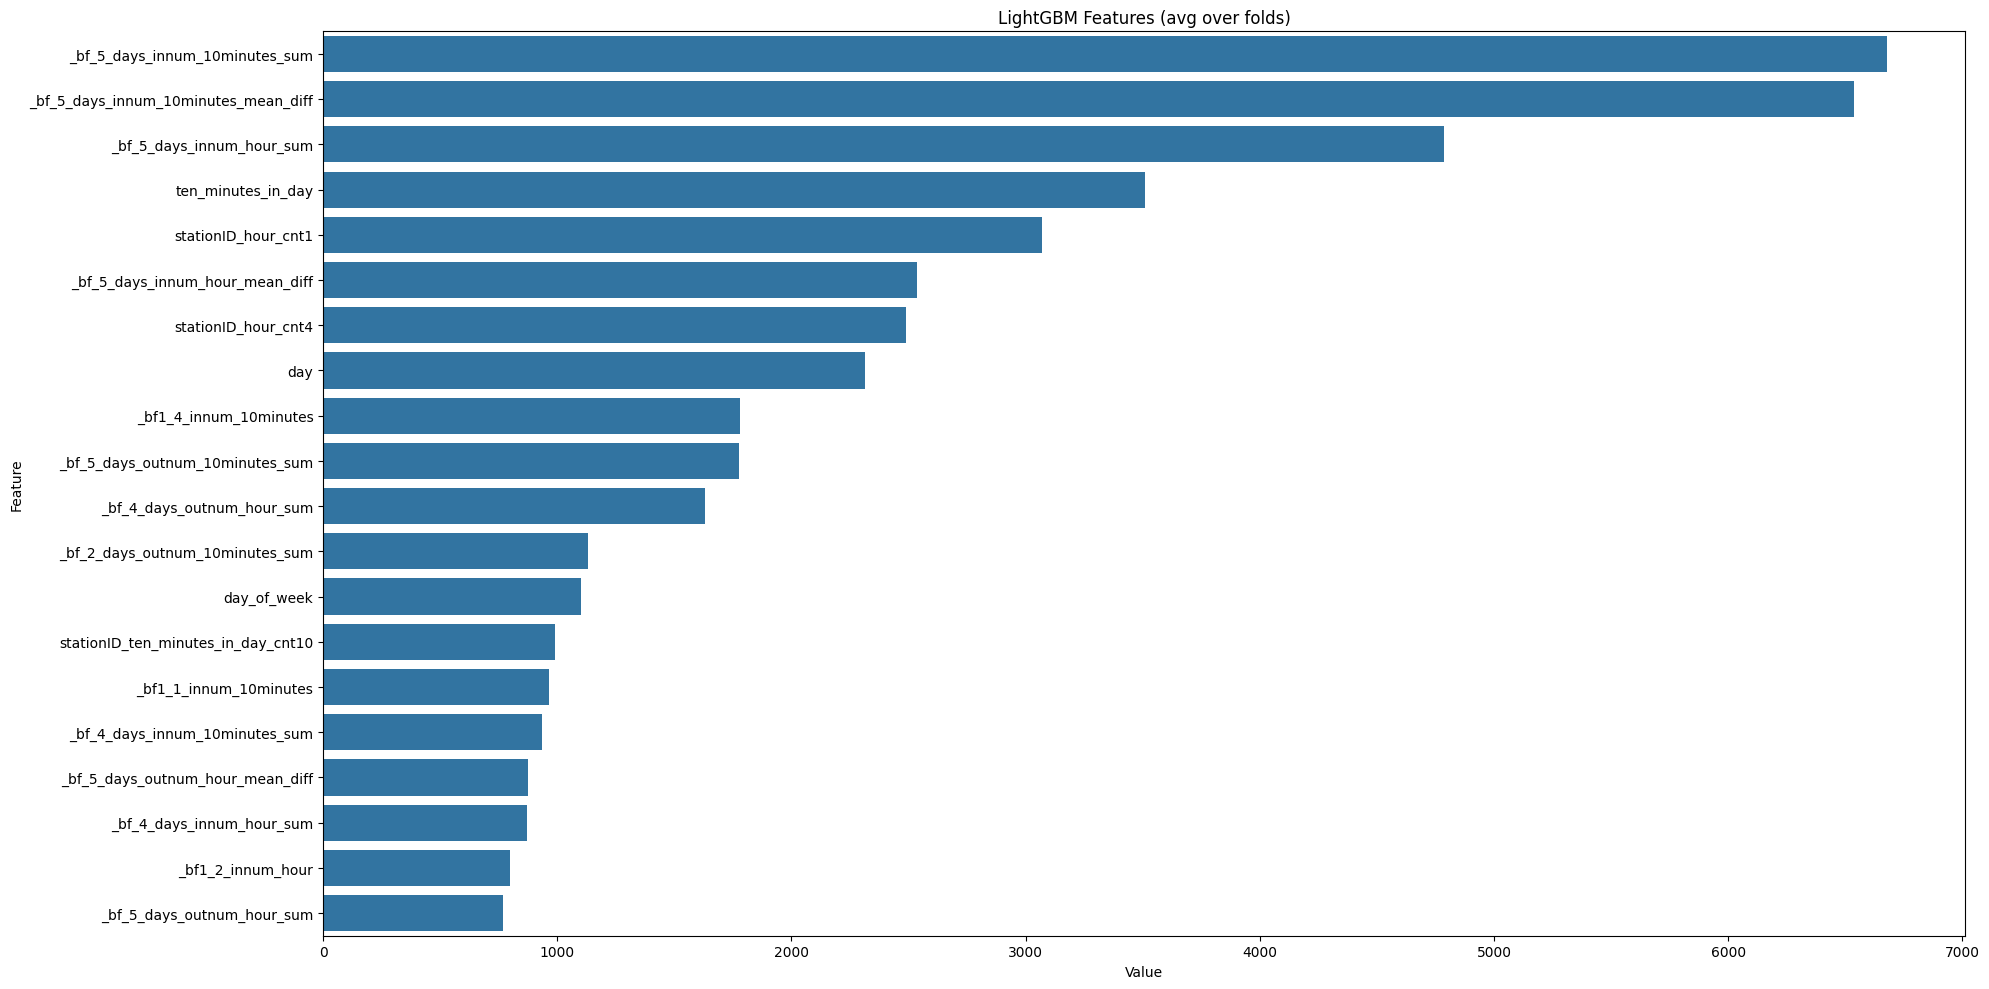

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,cols)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:20])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [27]:
# 特征选择
# new_cols = feature_imp.sort_values(by="Value", ascending=False)[100:]['Feature'].values.tolist()

In [28]:
# 开始训练
params = {'num_leaves': 63,'objective': 'regression_l1','max_depth': 5,'feature_fraction': 0.9,
         'learning_rate': 0.05,'boosting': 'gbdt','metric': 'mae','lambda_l1': 0.1}
model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model.fit(X_train, y_train_outNums, 
          eval_set=[(X_train, y_train_outNums), (X_valid, y_valid_outNums)], 
          eval_metric='mae',
          callbacks=callbacks)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31274
[LightGBM] [Info] Number of data points in the train set: 151632, number of used features: 262
[LightGBM] [Warning] feature_fraction 

LGBMRegressor(boosting='gbdt', feature_fraction=0.9, lambda_l1=0.1,
              learning_rate=0.05, max_depth=5, metric='mae', n_estimators=20000,
              n_jobs=-1, nthread=4, num_leaves=63, objective='regression_l1')

In [29]:
from sklearn.ensemble import RandomForestRegressor
rfg = RandomForestRegressor()
rfg.fit(X_train,y_train_inNums)
result = rfg.predict(X_valid)

from sklearn.metrics import mean_absolute_error as mae
mae(y_valid_inNums,result)

np.float64(14.182518289894832)

## 时序模型

In [30]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers import LSTM
from keras import callbacks
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


def build_model():
    model = Sequential()
    model.add(LSTM(512, input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(256))
    model.add(Activation(activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(64))
    model.add(Activation(activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(16))
    model.add(Activation(activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(1))

    return model

ModuleNotFoundError: No module named 'keras'

In [31]:
df_data = df_data.fillna(0)
scaler = StandardScaler()
scaler.fit(df_data[cols])

df_train = df_data[df_data.day<28]
df_valid = df_data[df_data.day==28]

X_train = df_train[cols].values
X_valid = df_valid[cols].values

X_train[:] = scaler.transform(X_train)
X_valid[:] = scaler.transform(X_valid)

# reshape
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid = X_valid.reshape((X_valid.shape[0], 1, X_valid.shape[1]))

# label
y_train_inNums = df_train['inNums'].values
y_valid_inNums = df_valid['inNums'].values

y_train_outNums = df_train['outNums'].values
y_valid_outNums = df_valid['outNums'].values

In [32]:
# 编译部分
model = build_model()
model.compile(loss='mae', optimizer=optimizers.Adam(lr=0.001), metrics=['mae'])
# 回调函数
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
earlystopping = EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='min')
callbacks = [reduce_lr, earlystopping]
# 训练部分
model.fit(X_train, y_train_inNums, batch_size = 256, epochs = 200, verbose=1,
        validation_data=(X_valid,y_valid_inNums), callbacks=callbacks, shuffle=True)

NameError: name 'build_model' is not defined

## 时序stacking

In [29]:
df_data = df_feature_y.copy()
df_data = df_data.merge(df_station, on ='stationID', how='left')
df_data = df_data.merge(df_station_metro, on ='stationID', how='left')

cols = [f for f in df_data.columns if f not in ['startTime','endTime','inNums','outNums']]

In [30]:
y_inNums = df_data[df_data.day<28]['inNums'].values
y_outNums = df_data['outNums'].values
df_train = df_data[df_data.day<28][cols].values
df_data = df_data[cols].values

In [31]:
# 开始训练
params = {'num_leaves': 63,'objective': 'regression_l1','max_depth': 5,'feature_fraction': 0.9,
         'learning_rate': 0.05,'boosting': 'gbdt','metric': 'mae','lambda_l1': 0.1}
model = lgb.LGBMRegressor(**params, n_estimators = 1500, nthread = 4)
model.fit(df_train, y_inNums)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31274
[LightGBM] [Info] Number of data points in the train set: 151632, number of used features: 262
[LightGBM] [Info] Start training from 

LGBMRegressor(boosting='gbdt', feature_fraction=0.9, lambda_l1=0.1,
              learning_rate=0.05, max_depth=5, metric='mae', n_estimators=1500,
              nthread=4, num_leaves=63, objective='regression_l1')

In [32]:
inNums_stacking = model.predict(df_data)
inNums_stacking

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


array([2.27122388e-32, 2.27122388e-32, 2.27122388e-32, ...,
       1.14888340e+01, 5.82428846e+00, 1.01207016e-01])

### 合并stacking特征

In [33]:
df_data = df_feature_y.copy()
df_data = df_data.merge(df_station, on ='stationID', how='left')
df_data = df_data.merge(df_station_metro, on ='stationID', how='left')

df_data['inNums_stacking'] = inNums_stacking

cols = [f for f in df_data.columns if f not in ['startTime','endTime','inNums','outNums']]

In [34]:
df_train = df_data[df_data.day<28][df_data.day>10]
df_valid = df_data[df_data.day==28]

X_train = df_train[cols].values
X_valid = df_valid[cols].values

y_train_inNums = df_train['inNums'].values
y_valid_inNums = df_valid['inNums'].values

y_train_outNums = df_train['outNums'].values
y_valid_outNums = df_valid['outNums'].values

In [35]:
# 开始训练
params = {'num_leaves': 63,'objective': 'regression_l1','max_depth': 5,'feature_fraction': 0.9,
         'learning_rate': 0.05,'boosting': 'gbdt','metric': 'mae','lambda_l1': 0.1}
model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model.fit(X_train, y_train_inNums, 
          eval_set=[(X_train, y_train_inNums), (X_valid, y_valid_inNums)], 
          eval_metric='mae',
          callbacks=callbacks)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31525
[LightGBM] [Info] Number of data points in the train set: 128304, number of used features: 263
[LightGBM] [Warning] feature_fraction 

LGBMRegressor(boosting='gbdt', feature_fraction=0.9, lambda_l1=0.1,
              learning_rate=0.05, max_depth=5, metric='mae', n_estimators=20000,
              n_jobs=-1, nthread=4, num_leaves=63, objective='regression_l1')